# Coding Project: Reproducing Salehi et al. with Transformers instead of VGG

### Installing packages

In [1]:
!git clone https://github.com/LucStrater/Knowledge_Distillation_AD.git
%cd /content/Knowledge_Distillation_AD

Cloning into 'Knowledge_Distillation_AD'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 160 (delta 65), reused 95 (delta 42), pack-reused 30
Receiving objects: 100% (160/160), 20.21 MiB | 15.34 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/Knowledge_Distillation_AD


In [2]:
# standard
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
import requests

# plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# tqdm for loading bars
from tqdm.notebook import tqdm

# eval
from sklearn.metrics import roc_curve, auc

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

# Huggingface transformers
try:
    from transformers import ViTImageProcessor, ViTForImageClassification
except ModuleNotFoundError:
    !pip install --quiet transformers
    from transformers import ViTImageProcessor, ViTForImageClassification

# wandb
try:
    import wandb
except ModuleNotFoundError:
    !pip install --quiet wandb
    import wandb

# paths
cwd = os.getcwd()
DATASET_PATH = f"{cwd}/data"
os.makedirs(DATASET_PATH, exist_ok=True)
CHECKPOINT_PATH = f"{cwd}/outputs/vit_checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# seeding
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-2-bd86a10fefa7>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

### Load data

Wrote my own dataloader as the original dataloader did not include a seperate validation and test set. Also I wanted to add augmentations as I read online that they are necessary to make ViTs work. I found a pretrained ViT on huggingface that was already fine tuned on CIFAR10 which I want to use and therefor I need to rescale CIFAR10 to 224x224. Lastly, I wanted to understand the data a bit better as before this data loading had been quite vague to me.

In [3]:
def prepare_cifar10_data_loaders(normal_class, batch_size, path, num_workers, seed):
    test_transform = transforms.Compose([transforms.Resize((256, 256), Image.LANCZOS),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                       ])
    train_transform = transforms.Compose([transforms.Resize((256, 256), Image.LANCZOS),
                                         transforms.RandomCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                       ])

    # load data
    train_dataset = CIFAR10(root=path, train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root=path, train=True, transform=test_transform, download=True)

    # split data
    pl.seed_everything(seed)
    train_indices, val_indices = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(seed))

    # filter the training dataset
    train_mask = np.array(train_dataset.targets) == normal_class
    filtered_train_indices = [idx for idx in train_indices.indices if train_mask[idx]]

    # create subsets
    train_set = torch.utils.data.Subset(train_dataset, filtered_train_indices)
    val_set = torch.utils.data.Subset(val_dataset, val_indices.indices)

    # test set
    test_set = CIFAR10(root=path, train=False, transform=test_transform, download=True)

    # data loaders
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers)
    val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

100%|██████████| 170498071/170498071 [00:08<00:00, 20693713.88it/s]


Extracting /content/Knowledge_Distillation_AD/data/cifar-10-python.tar.gz to /content/Knowledge_Distillation_AD/data
Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Seed set to 42


Files already downloaded and verified


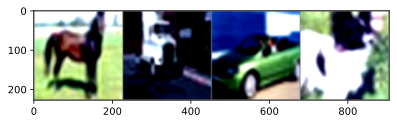

tensor([7, 9, 1, 5])

In [4]:
train_loader, val_loader, test_loader = prepare_cifar10_data_loaders(normal_class=3, batch_size=4, path=DATASET_PATH, num_workers=2, seed=42)

dataiter = iter(val_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
labels

### Understanding Huggingface pretrained ViTs

This chapter is just to see how to use Hugginface pretrained ViT works.

In [5]:
vit_pretrained = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', output_hidden_states=True)
processor_pretrained = ViTImageProcessor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

# preprocess
inputs = processor_pretrained(images=images, do_resize=False, do_rescale=False, do_normalize=False, return_tensors="pt")

# inference
with torch.no_grad():
    outputs = vit_pretrained(**inputs)

# predicted class
preds = outputs.logits.argmax(dim=1)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
predicted_class = []
for i in range(preds.shape[0]):
  predicted_class.append(classes[preds[i].item()])

print(predicted_class)

['horse', 'truck', 'automobile', 'cat']


In [6]:
print(outputs.hidden_states[12].shape)

torch.Size([4, 197, 768])


In [7]:
vit_pretrained

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### Helper functions

For training the ViT model I need a number of helper functions, which I (mostly) did not make myself. Here is a list:

* img_to_patch() and AttentionBlock() have been taken from a [tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html) by Philip Lippe. Aswell as VisionTransformer(), although that one I had to modify slightly to also output the hidden states.
* MseDirectionLoss() is taken from the original code-base, and slightly modified to make the dimensions match.

In [8]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [9]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [10]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)

        # output hidden states
        hidden_states = []
        for block in self.transformer:
            x = block(x)
            hidden_states.append(x.transpose(0, 1))

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out, hidden_states

In [11]:
class MseDirectionLoss(nn.Module):
    def __init__(self, lamda):
        super(MseDirectionLoss, self).__init__()
        self.lamda = lamda
        self.criterion = nn.MSELoss()
        self.similarity_loss = torch.nn.CosineSimilarity()

    def forward(self, output_pred, output_real):
        y_pred_0, y_pred_1, y_pred_2, y_pred_3 = output_pred[0], output_pred[1], output_pred[2], output_pred[3]


        y_0, y_1, y_2, y_3 = output_real[3], output_real[6], output_real[9], output_real[12]

        # different terms of loss
        abs_loss_0 = self.criterion(y_pred_0, y_0)
        loss_0 = torch.mean(1 - self.similarity_loss(y_pred_0.view(y_pred_0.shape[0], -1), y_0.view(y_0.shape[0], -1)))
        abs_loss_1 = self.criterion(y_pred_1, y_1)
        loss_1 = torch.mean(1 - self.similarity_loss(y_pred_1.view(y_pred_1.shape[0], -1), y_1.view(y_1.shape[0], -1)))
        abs_loss_2 = self.criterion(y_pred_2, y_2)
        loss_2 = torch.mean(1 - self.similarity_loss(y_pred_2.view(y_pred_2.shape[0], -1), y_2.view(y_2.shape[0], -1)))
        abs_loss_3 = self.criterion(y_pred_3, y_3)
        loss_3 = torch.mean(1 - self.similarity_loss(y_pred_3.view(y_pred_3.shape[0], -1), y_3.view(y_3.shape[0], -1)))

        total_loss = loss_0 + loss_1 + loss_2 + loss_3 + self.lamda * (
                abs_loss_0 + abs_loss_1 + abs_loss_2 + abs_loss_3)

        return total_loss

### ViT model

This is were the actual Knowledge Distillation for Anomaly Detection comes in. I decided to go for this pytorch lightning implementation so I needed to incorporate the detection_test() from the original code base here. The main idea is to use a ViT that is pretrained and fine-tuned on CIFAR10. Than to distill its capabilities into a smaller ViT that is trained here, the outputs of the hidden dimensions of multiple layers are forced to be similar to those of pretrained ViT.

In [12]:
class AD_ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr, lamda, normal_class, hf_path, milestones, gamma):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)

        # get pretrained ViT
        self.processor_pretrained = ViTImageProcessor.from_pretrained(hf_path)
        self.vit_pretrained = ViTForImageClassification.from_pretrained(hf_path, output_hidden_states=True).to(self.device)

        # freeze the pretrained model's parameters
        for param in self.vit_pretrained.parameters():
            param.requires_grad = False

        # loss function
        self.criterion = MseDirectionLoss(lamda)
        self.similarity_loss = torch.nn.CosineSimilarity()

        # init for evaluation
        self.val_scores = []
        self.val_labels = []
        self.test_scores = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)[0]

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.hparams.milestones, gamma=self.hparams.gamma)
        return [optimizer], [lr_scheduler]

    def _step(self, batch, mode="train"):
        images, _ = batch
        images = images.to(self.device)

        # inference
        output_pred = self.model(images)[1]

        # inference with the pretrained model
        inputs = self.processor_pretrained(images=images, do_resize=False, do_rescale=False, do_normalize=False, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        output_real = self.vit_pretrained(**inputs).hidden_states

        # loss
        loss = self.criterion(output_pred, output_real)
        self.log(f'{mode}_loss', loss)

        return loss, output_pred, output_real

    def _eval_step(self, batch, mode="val"):
        loss, output_pred, output_real = self._step(batch, mode=mode)

        _, labels = batch
        target_class = self.hparams.normal_class
        labels = torch.where(labels == target_class, 1, 0)

        y_pred_1, y_pred_2, y_pred_3 = output_pred[1], output_pred[2], output_pred[3]
        y_1, y_2, y_3 = output_real[6], output_real[9], output_real[12]

        abs_loss_1 = torch.mean((y_pred_1 - y_1) ** 2, dim=(1, 2))
        loss_1 = 1 - self.similarity_loss(y_pred_1.view(y_pred_1.shape[0], -1), y_1.view(y_1.shape[0], -1))
        abs_loss_2 = torch.mean((y_pred_2 - y_2) ** 2, dim=(1, 2))
        loss_2 = 1 - self.similarity_loss(y_pred_2.view(y_pred_2.shape[0], -1), y_2.view(y_2.shape[0], -1))
        abs_loss_3 = torch.mean((y_pred_3 - y_3) ** 2, dim=(1, 2))
        loss_3 = 1 - self.similarity_loss(y_pred_3.view(y_pred_3.shape[0], -1), y_3.view(y_3.shape[0], -1))
        scores = loss_1 + loss_2 + loss_3 + self.hparams.lamda * (abs_loss_1 + abs_loss_2 + abs_loss_3)

        return scores, labels

    def _eval_epoch_end(self, scores, labels, mode="val"):
        all_scores = torch.cat(scores, dim=0)
        all_labels = torch.cat(labels, dim=0)

        # numpy
        scores_np = all_scores.view(-1).cpu().numpy()
        labels_np = all_labels.view(-1).cpu().numpy()

        # calculate ROC AUC
        fpr, tpr, thresholds = roc_curve(labels_np, scores_np, pos_label=0)
        roc_auc = auc(fpr, tpr)
        roc_auc = round(roc_auc, 4)
        self.log(f'{mode}_roc_auc', roc_auc, on_epoch=True, prog_bar=True)

        return roc_auc

    def training_step(self, batch, batch_idx):
        loss, _, _ = self._step(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        scores, labels = self._eval_step(batch, mode="val")
        self.val_scores.append(scores)
        self.val_labels.append(labels)

    def test_step(self, batch, batch_idx):
        scores, labels = self._eval_step(batch, mode="test")
        self.test_scores.append(scores)
        self.test_labels.append(labels)

    def on_validation_epoch_end(self):
        val_result = self._eval_epoch_end(self.val_scores, self.val_labels, mode="val")
        self.val_scores = []
        self.val_labels = []

    def on_test_epoch_end(self):
        test_result = self._eval_epoch_end(self.test_scores, self.test_labels, mode="test")
        self.test_scores = []
        self.test_labels = []



### Training
This is standard huggingface stuff.

In [13]:
def train_model(**kwargs):
    normal_class = kwargs.get('normal_class')
    seed = 42

    # logging
    wandb.init(project='AD_ViT_CIFAR10', entity='lucstrater', name=f'class_{normal_class}')
    wandb_logger = WandbLogger()

    trainer = pl.Trainer(log_every_n_steps=5,
                         logger=wandb_logger,
                         default_root_dir=os.path.join(CHECKPOINT_PATH, f'AD_ViT_CIFAR10_class_{normal_class}'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_roc_auc"),
                                    LearningRateMonitor("epoch")])

    # get dataloaders
    train_loader, val_loader, test_loader = prepare_cifar10_data_loaders(normal_class=normal_class, batch_size=128, path=DATASET_PATH, num_workers=2, seed=seed)

    # train
    pl.seed_everything(seed)
    model = AD_ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = AD_ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # test
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_roc_auc"], "val": val_result[0]["test_roc_auc"]}

    # logging
    wandb.finish()

    return model, result

In [15]:
wandb.login()

model, results = train_model(model_kwargs={
                                'embed_dim': 768,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 4,
                                'patch_size': 16,
                                'num_channels': 3,
                                'num_patches': 196,
                                'num_classes': 10,
                                'dropout': 0.2
                            },
                            lr=5e-5, lamda=0.01, normal_class=0, hf_path='nateraw/vit-base-patch16-224-cifar10', milestones=[5], gamma=0.2)
print("ViT results", results)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lucstrater. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Seed set to 42


Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                      | Params
--------------------------------------------------------------
0 | model           | VisionTransformer         | 13.4 M
1 | vit_pretrained  | ViTForImageClassification | 85.8 M
2 | criterion       | MseDirectionLoss          | 0     
3 | similarity_loss | CosineSimilarity          | 0     
--------------------------------------------------------------
13.4 M    Trainable params
85.8 M    Non-trainable params
99.2 M    Total params
396.683   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
lr-AdamW,█████▁▁▁▁▁
test_loss,█▁
test_roc_auc,█▁
train_loss,██▆▅▅▅▄▄▄▃▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,▆█▆▃▂▂▂▁▂▁
val_roc_auc,▁▆▇▇██████
epoch,10
lr-AdamW,1e-05
test_loss,9.39199


ViT results {'test': 0.9678, 'val': 0.9708}
